# Ürün Öneri Sistemi: En Çok Birlikte Alınan Ürünler Analizi
Bu notebook'ta, MinIO'da saklanan satın alma verilerinden aynı alışverişte en çok birlikte alınan ürün çiftlerini PySpark kullanarak analiz edeceğiz.


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, collect_set, col
from itertools import combinations
import matplotlib.pyplot as plt


In [6]:
import os
from pyspark.sql import SparkSession

os.environ['AWS_ACCESS_KEY_ID'] = 'minioadmin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'minioadmin'

spark = SparkSession.builder \
    .appName("ProductPairAnalysis") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()


In [7]:
df = spark.read.parquet("s3a://purchased-items/valid/")
df.printSchema()
df.show(5)


root
 |-- SessionId: string (nullable = true)
 |-- TimeStamp: timestamp (nullable = true)
 |-- UserId: string (nullable = true)
 |-- TotalPrice: double (nullable = true)
 |-- OrderId: string (nullable = true)
 |-- PaymentType: string (nullable = true)
 |-- Products: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- ProductId: string (nullable = true)
 |    |    |-- ItemCount: integer (nullable = true)
 |    |    |-- ItemPrice: double (nullable = true)
 |    |    |-- ItemDiscount: double (nullable = true)

+--------------------+-------------------+--------------------+----------+--------------------+--------------+--------------------+
|           SessionId|          TimeStamp|              UserId|TotalPrice|             OrderId|   PaymentType|            Products|
+--------------------+-------------------+--------------------+----------+--------------------+--------------+--------------------+
|              abc888|2025-07-16 14:10:00|              

In [8]:
# Her siparişteki ürünleri grupla
order_products = df.select("OrderId", explode("Products.ProductId").alias("ProductId")) \
    .groupBy("OrderId") \
    .agg(collect_set("ProductId").alias("product_set"))

order_products.show(5)


+--------------------+--------------------+
|             OrderId|         product_set|
+--------------------+--------------------+
|002ea6b1-8ec4-4a3...|[f498620a-759f-49...|
|0044c361-39b5-47d...|[7b00da3a-2c27-42...|
|00745edf-1c63-4fc...|[7417fd5c-ad5d-4a...|
|007b641b-8735-4c4...|[8fb88501-153e-42...|
|0095410c-ee4e-403...|[d08f2795-ced4-46...|
+--------------------+--------------------+
only showing top 5 rows



In [9]:
# Helper fonksiyon: ürün setinden tüm benzersiz (unordered) çiftleri çıkarır
def get_pairs(row):
    items = row['product_set']
    return [(a, b) for a, b in combinations(sorted(items), 2)]

pairs_rdd = order_products.rdd.flatMap(get_pairs)
pairs_df = spark.createDataFrame(pairs_rdd, ["ProductA", "ProductB"])
pairs_df.show(5)


+--------------------+--------------------+
|            ProductA|            ProductB|
+--------------------+--------------------+
|6cb58e5a-009e-457...|c391d36e-eb88-4f1...|
|6cb58e5a-009e-457...|f498620a-759f-495...|
|c391d36e-eb88-4f1...|f498620a-759f-495...|
|541c80f2-562a-403...|7b00da3a-2c27-429...|
|541c80f2-562a-403...|864b2e84-ddcd-404...|
+--------------------+--------------------+
only showing top 5 rows



In [10]:
pair_counts = pairs_df.groupBy("ProductA", "ProductB").count().orderBy(col("count").desc())
pair_counts.show(10)  # En çok birlikte alınan ilk 10 çift


+--------------------+--------------------+-----+
|            ProductA|            ProductB|count|
+--------------------+--------------------+-----+
|d53b8131-49e6-49f...|f1871f6c-2d9c-4fd...|    1|
|36d40fdc-df61-4c3...|c53c31ae-fa17-46a...|    1|
|05a6348a-c311-449...|09baec43-0403-482...|    1|
|84dffbe5-d4d5-460...|cb7bf70a-8b86-432...|    1|
|123d367e-c62d-475...|beb3eaeb-07e7-44c...|    1|
|73c56207-a444-4f8...|e6822c1c-e340-4a7...|    1|
|33da4cff-f496-419...|f9665aff-92b7-47a...|    1|
|224fbf6c-e17f-4c4...|cab574f2-b629-484...|    1|
|243933b9-6e08-4c4...|cf652f9a-c1b5-432...|    1|
|42a240cf-d048-4d2...|a1d0f8f2-3e9b-45c...|    1|
+--------------------+--------------------+-----+
only showing top 10 rows



In [11]:
# Pandas ile çıktı almak
import pandas as pd

pair_counts_pd = pair_counts.limit(20).toPandas()
pair_counts_pd


,ProductA,ProductB,count
0,d53b8131-49e6-49f4-9473-51e72a733968,f1871f6c-2d9c-4fd5-9836-dfcba11ce510,1
1,36d40fdc-df61-4c39-83d9-e47a924377cf,c53c31ae-fa17-46a5-93a1-0291fa054e75,1
2,05a6348a-c311-4495-a7af-952dec498902,09baec43-0403-482c-9ebf-10196342f0ef,1
3,84dffbe5-d4d5-4608-98aa-ce51808ba2e2,cb7bf70a-8b86-432e-a571-91a261bca641,1
4,123d367e-c62d-475f-9710-24f718519f74,beb3eaeb-07e7-44ca-a0ae-6ec5fd248c9d,1
5,73c56207-a444-4f8a-a670-f074d3e50040,e6822c1c-e340-4a75-ba7a-553f9807c0d6,1
6,33da4cff-f496-4199-8f56-efde384cf90d,f9665aff-92b7-47ad-9f6d-2456502ed8cb,1
7,224fbf6c-e17f-4c41-9a0f-a387dc6a3e83,cab574f2-b629-4849-ae49-20ef4250c8d8,1
8,243933b9-6e08-4c4a-84ca-f9db93268409,cf652f9a-c1b5-4322-b5fb-03cd2926da16,1
9,42a240cf-d048-4d26-9397-26165d3a6f92,a1d0f8f2-3e9b-45c4-94ec-8a286223defd,1


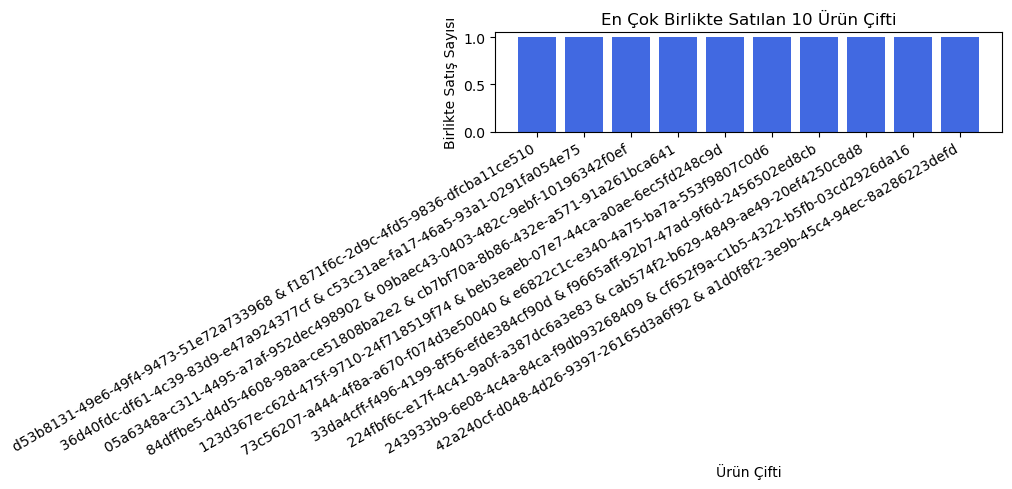

In [12]:
import matplotlib.pyplot as plt

# ilk 10 en çok birlikte satılan ürünü alıyoruz
pair_counts_pd = pair_counts.limit(10).toPandas()
pair_counts_pd['Ürün Çifti'] = pair_counts_pd['ProductA'].astype(str) + ' & ' + pair_counts_pd['ProductB'].astype(str)

plt.figure(figsize=(10, 5))
plt.bar(pair_counts_pd['Ürün Çifti'], pair_counts_pd['count'], color='royalblue')
plt.xlabel('Ürün Çifti')
plt.ylabel('Birlikte Satış Sayısı')
plt.title('En Çok Birlikte Satılan 10 Ürün Çifti')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig('en_cok_birlikte_alan_ciftler.png', dpi=120)  # <-- PNG olarak kaydedilir
plt.show()


## Müşteri Segmentasyonu: KMeans ile Analiz

Bu bölümde, satın alma verilerinden müşteri gruplarını bulmak için KMeans algoritması kullanılacaktır. Kumeleme ile VIP, düzenli ve nadir alışveriş yapan müşteri segmentlerini ortaya çıkarmak, pazarlama ve kişiselleştirilmiş öneri/indirim stratejileri için faydalıdır.


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [13]:
from pyspark.sql.functions import sum as spark_sum, count as spark_count

# Ana Spark dataframe'in adı genelde df olur
customer_features = df.groupBy("UserId").agg(
    spark_sum("TotalPrice").alias("TotalSpending"),
    spark_count("OrderId").alias("OrderCount")
)
customer_features_pd = customer_features.toPandas()
customer_features_pd.head()


,UserId,TotalSpending,OrderCount
0,8b22b5c6-4f0d-4d3a-857f-e3d7fd2dee89,1241.70,1
1,6326ee7b-1f7e-4334-9cae-0f7a3cf487e6,5720.74,1
2,0d4fd0d0-85e6-42e2-8212-a9eb9886371c,4457.62,1
3,73e1e7fc-9946-4d97-be58-5e5982877081,3572.13,1
4,5d80c9f2-ddc4-45da-bada-65c167493947,4420.85,1


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_features_pd[["TotalSpending", "OrderCount"]])


In [15]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_features_pd["Segment"] = kmeans.fit_predict(X_scaled)
customer_features_pd.head()


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,UserId,TotalSpending,OrderCount,Segment
0,8b22b5c6-4f0d-4d3a-857f-e3d7fd2dee89,1241.70,1,0
1,6326ee7b-1f7e-4334-9cae-0f7a3cf487e6,5720.74,1,1
2,0d4fd0d0-85e6-42e2-8212-a9eb9886371c,4457.62,1,0
3,73e1e7fc-9946-4d97-be58-5e5982877081,3572.13,1,0
4,5d80c9f2-ddc4-45da-bada-65c167493947,4420.85,1,0


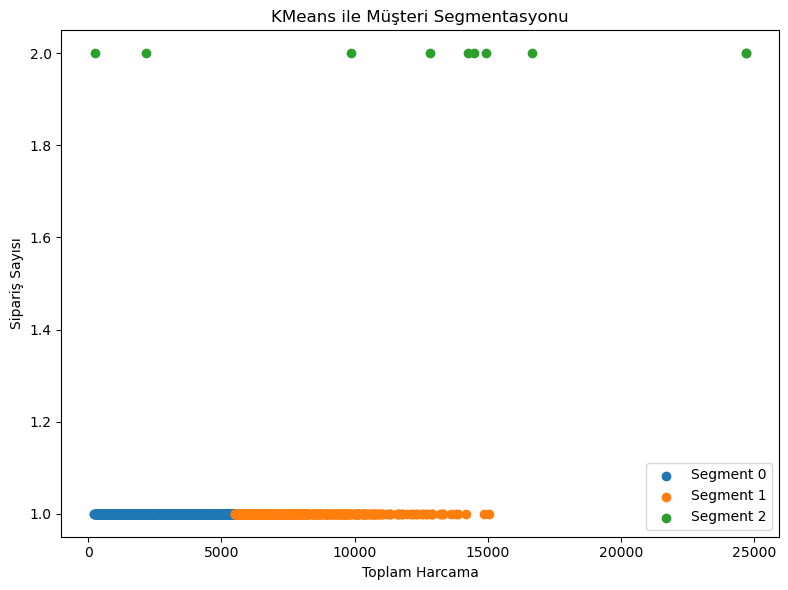

In [19]:
plt.figure(figsize=(8,6))
for segment in customer_features_pd["Segment"].unique():
    seg_data = customer_features_pd[customer_features_pd["Segment"] == segment]
    plt.scatter(
        seg_data["TotalSpending"], 
        seg_data["OrderCount"],
        label=f"Segment {segment}"
    )
plt.xlabel("Toplam Harcama")
plt.ylabel("Sipariş Sayısı")
plt.title("KMeans ile Müşteri Segmentasyonu")
plt.legend()
plt.tight_layout()
plt.show()


# Sonuç:  > Verideki müşteri alışkanlıkları büyük çoğunlukla tek seferlik alışverişlerden oluşuyor; yalnızca birkaç kişinin birden fazla siparişi mevcut. 
> Bu yüzden KMeans segmentasyonu ile anlamlı müşteri profilleri oluşturulamıyor. 
> Daha çeşitli veriyle, örneğin farklı alışveriş sıklıkları ve harcama dağılımlarında, segmentler ("VIP", "sadık müşteri" vb.) ayrışabili
lir.
